### Catboost1

In [1]:
import pandas as pd
import numpy as np
import catboost as cat

In [2]:
print(cat.__version__)

1.0.4


In [3]:
# globals
FIGSIZE = (9, 6)

SEED = 42

FILE_TRAIN = "train.csv"

In [4]:
#
# my split in train, test set
#
def my_train_test_split(df, frac):
    # frac: the fraction used for train
    # df: the dataframe
    
    # shuffle before split
    df = df.sample(frac=1., random_state=SEED)

    # FRAC = 0.90
    tot_rec = df.shape[0]
    NUM_TRAIN = int(frac*tot_rec)
    NUM_TEST = tot_rec - NUM_TRAIN

    data_train = df[:NUM_TRAIN]
    data_test = df[NUM_TRAIN:]

    print()
    print('Numero totale di campioni:', tot_rec)
    print('Numero di campioni nel TRAIN SET:', data_train.shape[0])
    print('Numero di campioni nel TEST SET:', data_test.shape[0])
    
    return data_train, data_test

In [5]:
data_orig = pd.read_csv(FILE_TRAIN)

In [6]:
all_columns = data_orig.columns

# colonne da ignorare
del_columns = ['datetime', 'casual', 'registered']

TARGET = "count"

cat_cols = ['season', 'holiday','workingday', 'weather']

num_cols = list(set(all_columns) - set([TARGET]) - set(del_columns) - set(cat_cols))

features = sorted(cat_cols + num_cols)

print('Tutte le colonne:', len(all_columns))
print('Colonne ignorate:', len(del_columns))
print('target:', len([TARGET]))
print('Colonne cat:', len(cat_cols))
print('Colonne num:', len(num_cols))

Tutte le colonne: 12
Colonne ignorate: 3
target: 1
Colonne cat: 4
Colonne num: 4


In [7]:
data_used = data_orig.drop(del_columns, axis=1)

In [8]:
FRAC = 0.90

data_train, data_test = my_train_test_split(data_used, frac=FRAC)


Numero totale di campioni: 10886
Numero di campioni nel TRAIN SET: 9797
Numero di campioni nel TEST SET: 1089


In [9]:
# separo X ed y
x_train = data_train[features]
y_train = data_train[TARGET]

x_test = data_test[features]
y_test = data_test[TARGET]

# cat boost want indexes
cat_columns_idxs = [i for i, col in enumerate(x_train.columns) if col in cat_cols]

In [11]:
%%time
# First: try without addressing data imbalance

params = {'iterations':5000,
          'learning_rate':0.005,
          'depth':10,
          # 'task_type':"GPU"
         }

model = cat.CatBoostRegressor(**params)

model.fit(x_train, y_train, cat_columns_idxs, verbose=500, early_stopping_rounds=50, eval_set=(x_test, y_test))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 181.2924335	test: 177.2361404	best: 177.2361404 (0)	total: 63.4ms	remaining: 5m 17s
500:	learn: 144.8574922	test: 148.3806822	best: 148.3806822 (500)	total: 4.16s	remaining: 37.3s
1000:	learn: 140.5677347	test: 146.4208006	best: 146.4208006 (1000)	total: 7.71s	remaining: 30.8s
1500:	learn: 138.3806358	test: 145.6608980	best: 145.6590817 (1498)	total: 11.1s	remaining: 25.9s
2000:	learn: 136.3696374	test: 145.1748618	best: 145.1748618 (2000)	total: 14.7s	remaining: 22.1s
2500:	learn: 134.0280458	test: 144.7048111	best: 144.7048111 (2500)	total: 19.1s	remaining: 19.1s
3000:	learn: 132.1585530	test: 144.4371816	best: 144.4368298 (2993)	total: 23.6s	remaining: 15.7s
3500:	learn: 130.5283302	test: 144.2648571	best: 144.2634861 (3491)	total: 28.2s	remaining: 12.1s
4000:	learn: 128.8305712	test: 144.0774840	best: 144.0774840 (4000)	total: 32.9s	remaining: 8.22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 144.0559606
bestIteration = 4091

Shrink model to first 40

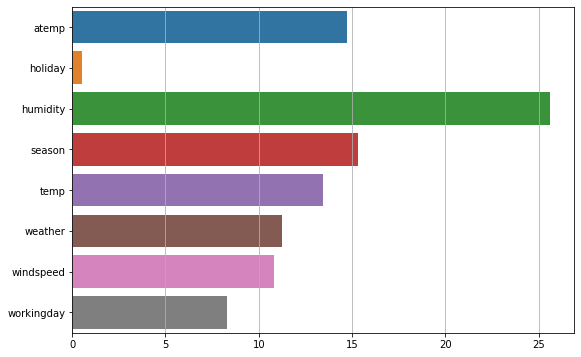

In [12]:
%matplotlib inline

# eXplainability: Feature importance
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = FIGSIZE)
plt.grid(True)
sns.barplot(x = model.get_feature_importance(), y = features);

### Submission to Kaggle

In [ ]:
test_orig = pd.read_csv("test.csv")

In [ ]:
v_test = test_orig[features]

In [ ]:
score_test = model.predict(v_test)

In [ ]:
score_test.shape

In [ ]:
df_sub = pd.read_csv("sampleSubmission.csv")

In [ ]:
df_sub["count"] = score_test

In [ ]:
condition = df_sub["count"] < 0

df_sub.loc[condition, "count"] = 0

In [ ]:
df_sub.describe()

In [ ]:
FILE_SUB = "submission1.csv"

df_sub.to_csv(FILE_SUB, index=False)

In [ ]:
!kaggle competitions submit -c "bike-sharing-demand" -f $FILE_SUB -m "sub1"